# Preface
This kernel is an introduction into machine learning hosted by the Explore Data Science Academy. This final version is a submission to the House Prices competition, but the objective is ultimately to learn the methods of linear regression.

This kernel varies vastly over its many submissions as we explored the methods of regression. Ultimately we narrowed it down to regularized linear regression models, as basic non-linear methods performed too poorly and parameter optimization is too computationally expensive and requires further study.

This is our first venture into machine learning, so it is not perfect, but we take pride in our work and we will revisit this kernel until we reach a score above 0.1.

Any comments or tips to help us in this venture will be welcomed

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, boxcox_normmax
from sklearn import preprocessing
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.special import boxcox1p, inv_boxcox
from sklearn import metrics

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Function Definitions

These are sets of functions which can be called along the various processes in this notebook and allow for faster iterations.

Linear regression methods' prediction accuracy rely on normally distributed data.
This function finds highly skewed columns (greater than 0.5) in a dataframe and applies log transformation to them.

In [2]:
def NormalizeData(df):
    '''
    Normalize your dataframe.
    Arguments:
        df - Dataframe to normalize
    Returns: df - Dataframe normalized by boxcox1p method from scipy.special
    '''
    # get all numeric columns
    num_cols = df._get_numeric_data().columns
    # calculate skewness
    skew_features = df[num_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
    
    # identify values with high skewness
    high_skew = skew_features[skew_features > 0.5]
    skew_index = high_skew.index
    
    # normalize values with boxcox transformation
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1))
    
    return df 

Having identified seven ordinal columns with a high correlation with the target feature, this function assigns numeric values to each category of each ordinal column and changes the column to numeric.

In [3]:
def OrdinalsToNumerics(df):    
    '''
    Assigns numerical values to ordinal features present in the dataframe. 
    Arguments:
        df - dataframe to convert predetermined ordinal numbers to numeric
    Returns: none
    '''
    
    # assign numeric values to ordinal columns
    df['ExterQual'] = df['ExterQual'].map(lambda x: {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}.get(x, 0))
    df['BsmtQual'] = df['BsmtQual'].map(lambda x: {'NA':1,'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6}.get(x, 0))
    df['KitchenQual'] = df['KitchenQual'].map(lambda x: {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}.get(x, 0))
    df['GarageFinish'] = df['GarageFinish'].map(lambda x: {'NA':1, 'Unf':2, 'RFn':3, 'Fin':4}.get(x, 0))
    df['FireplaceQu'] = df['FireplaceQu'].map(lambda x: {'NA':1,'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6}.get(x, 0))
    df['HeatingQC'] = df['HeatingQC'].map(lambda x: {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}.get(x, 0))
    
    # change dtype to numeric
    df['OverallQual'] = pd.to_numeric(df['OverallQual'])
    df['ExterQual'] = pd.to_numeric(df['ExterQual'])
    df['BsmtQual'] = pd.to_numeric(df['BsmtQual'])
    df['KitchenQual'] = pd.to_numeric(df['KitchenQual'])
    df['GarageFinish'] = pd.to_numeric(df['GarageFinish'])
    df['FireplaceQu'] = pd.to_numeric(df['FireplaceQu'])
    df['HeatingQC'] = pd.to_numeric(df['HeatingQC'])

Since linear regression models cannot handle object types, this function encodes categorical features with pandas' get_dummies function. It then splits the dataframe into the test and train dataframes.

In [4]:
def EncodeData(df):
    '''
    Converts categorical data into dummy variables.
    Arguments: 
        df - dataframe to encode.
    Returns: test - encoded features from the original unmerged dataframe (df_test).
             X - encoded features from the original unmerged dataframe (df_train), without the column 'SalePrice'.
    '''
    # encode df with get_dummies    
    code_df = pd.get_dummies(df, drop_first=True)
    
    # split test and train
    test = code_df[df_train.shape[0]:]
    X = code_df[:df_train.shape[0]]
    
    return test, X

This function initializes and fits a model to specified data. It was created to reduce redundant code.

In [5]:
def FitModel(model, X, y):
    '''
    Fits a regression model to the given dependent and independent variables.
    Arguments: 
        model - model to train.
        X - dataframe of independant variables.
        y - dataframe of dependant variable.
    Returns: a fitted model
    '''
    
    my_model = model
    
    return my_model.fit(X, y)

The otherwise versatile SKLearn package does not have a root mean squared error function, so this function calculates the square root of the mean squared error. 

In [6]:
def RMSE(test_y, y_pred):
    '''
    Calculates the Mean Squared Error for the fitted regression model.
    Arguments:
        test_y - the dependent variable for the data (actual y).
        y_pred - the dependent variable predicted by the model (predicted y).
    Returns: Root-mean-Squared error value. 
    '''
    return np.sqrt(mean_squared_error(test_y, y_pred))

We created this function in order to effectively find the best value for model parameters. Using SKLearn's GridSearchCV, we run many iterations of the same model within a defined parameter range, graph the score for each iteration and print the best parameter, rmse for training set and rmse for testing set.

In [7]:
def EvaluateModel(model, grid_param):
    '''
    Makes evaluations of the given regression model using various hyperparameter settings from GridSearchCV.
    Arguments:
        model - model to evaluate.
        grid_param - the settings which user wants t test on the given model.
    Returns: 
        Best params - the best hyperparameter settings for the given model.
        RMSE train - Root-Mean-Squared Error when running the train data. 
        RMSE test - Root-Mean-Squared Error when running the test data.
    '''      
    # initialize gridsearch
    gs = GridSearchCV(estimator=model, param_grid=grid_param, cv=5)
    
    # fit gridsearch to data
    gs.fit(X_train, y_train)
    
    # graphing
    keys  = list(grid_param[0].keys())
    length = [len(grid_param[0][x]) for x in keys]
    scores = gs.cv_results_['mean_test_score']
    scores = np.array(scores).reshape(tuple(length))
    
    if len(keys) > 1:
        plt.figure(figsize=(10,5))
        for ind, i in enumerate(grid_param[0]['alpha']):
            plt.plot(grid_param[0]['l1_ratio'], scores[ind])
        plt.xlabel('l1_ratio')
        plt.ylabel('Mean score')
        plt.show()
    
    else:
        plt.figure(figsize=(10,5))
        plt.plot(scores)
        plt.xlabel('alpha')
        plt.ylabel('Mean score')
        plt.show()
        
    best_model = gs.best_estimator_
    train_rmse = RMSE(y_train, best_model.predict(X_train))
    test_rmse = RMSE(y_test,  best_model.predict(X_test))
    
    # print findings
    print('Best params: {}'.format(gs.best_params_))
    print("RMSE train: {}".format(train_rmse))
    print("RMSE test : {}".format(test_rmse))
    
    return [train_rmse, test_rmse]

This function estimates SalePrice values from a given dataframe using a specified model. It then rescales these predictions with inverse boxcox transformations. Finally it creates a dataframe from these estimated SalePrice values and the Id column from the test dataframe and outputs them to a csv with an optional custom name.

In [8]:
def Submit(model, test, csv_name='submission.csv'):
    '''
    Creates a csv document of the results from the given model. 
    Arguments: 
        model - model to predict.
        test - dataframe of independant variables
        csv_name - custom name for the csv (optional)
    Return: csv file with the test ids and results from running the model on the test data.
    '''
    
    # predict target values
    predictions = model.predict(test)
    # rescale predictions
    rescaled = inv_boxcox(predictions, maxlog)
    # create submission df
    submit_df = pd.DataFrame({'Id': test_id, 'SalePrice': rescaled})
    # output submission df to csv
    submit_df.to_csv(csv_name, index=False)
    
    return print('Submissions printed to', csv_name)

# 1. Exploratory Data Analysis

## 1.1 Data Preparation

### Initial Dataframes

In [9]:
'''
Loading dataframes from csvs.
'''
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### Target Feature Distribution and Normalization

When using non-invariant regression methods such as LASSO or Ridge, predictive accuracy benefits from normalized data. Since regression assumes multivariate normality, skewed data violates this and leads to erroneous predictions.

C:\Users\Zandi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Zandi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


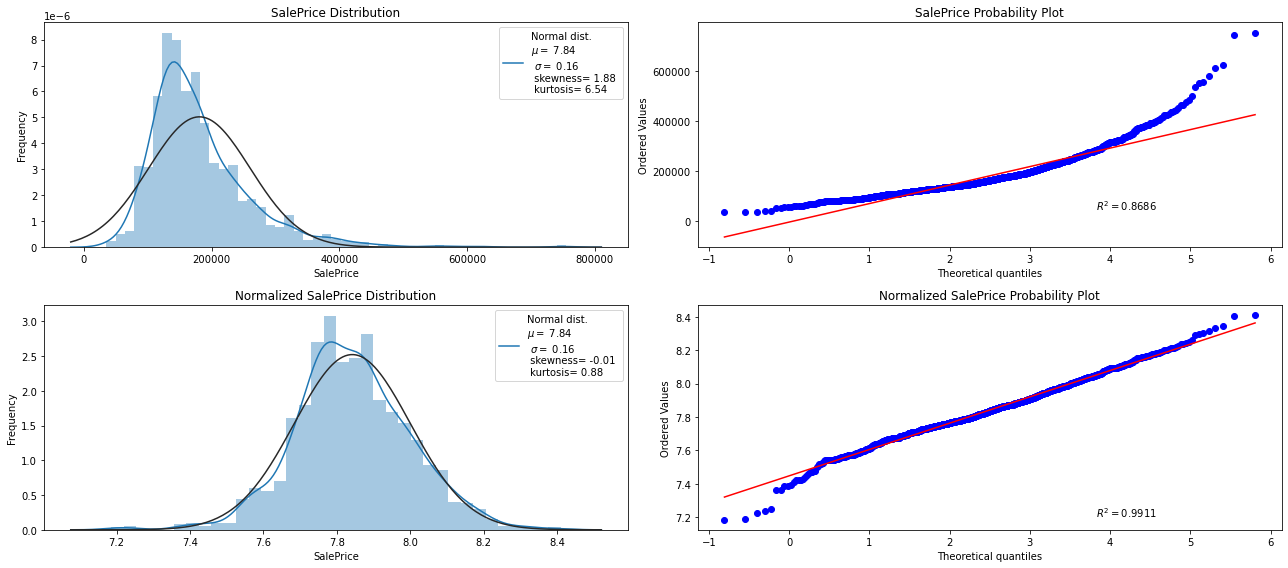

In [10]:
'''
    Transforming SalePrice with boxcox and plotting distribution of original vs transformed SalePrice.
'''

saleprice = df_train['SalePrice']
df_train['SalePrice'], maxlog = stats.boxcox(df_train['SalePrice'])
mu, sigma = norm.fit(df_train['SalePrice'])
skewness = saleprice.skew()
kurtosis = saleprice.kurt()
trans_skew = df_train['SalePrice'].skew()
trans_kurt = df_train['SalePrice'].kurt()

plt.figure(figsize=(18,8))

plt.subplot(221)
sns.distplot(saleprice , fit=norm)
plt.legend(['Normal dist. \n$\mu=$ {:.2f} \n $\sigma=$ {:.2f} \n skewness= {:.2f} \n kurtosis= {:.2f}'.format(mu, sigma,skewness,kurtosis)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice Distribution')

plt.subplot(222)
res = stats.probplot(saleprice, sparams=(2.5,), plot=plt, rvalue=True)
plt.title('SalePrice Probability Plot')


plt.subplot(223)
sns.distplot(df_train['SalePrice'] , fit=norm)
plt.legend(['Normal dist. \n$\mu=$ {:.2f} \n $\sigma=$ {:.2f} \n skewness= {:.2f} \n kurtosis= {:.2f}'.format(mu, sigma,trans_skew,trans_kurt)],loc='best')

plt.ylabel('Frequency')
plt.title('Normalized SalePrice Distribution')

plt.subplot(224)
res = stats.probplot(df_train['SalePrice'], sparams=(2.5,), plot=plt, rvalue=True)
plt.title('Normalized SalePrice Probability Plot')
plt.tight_layout()

### Removing Outliers

Outliers in data have a major affect on regression. We identified two outliers (denoted by the 'x's in the graph below) and removed them from the training set.

Text(0.5, 1.0, 'GrLivArea vs SalePrice')

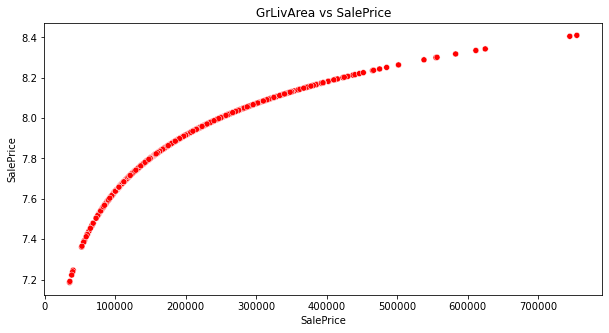

In [11]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=saleprice,y=df_train['SalePrice'], style=(df_train['GrLivArea'] > 4500), legend=None,color='red')
plt.title('GrLivArea vs SalePrice')

In [13]:
'''
    Remove two outliers of GrLivArea.
'''
df_train = df_train.drop(df_train.sort_values(by = 'GrLivArea', ascending = False)[:2].index)

### Calculating Correlation with Target Feature

We calculated the correlation of all features and the target variable. Below we display both the highest and least correlated features. 

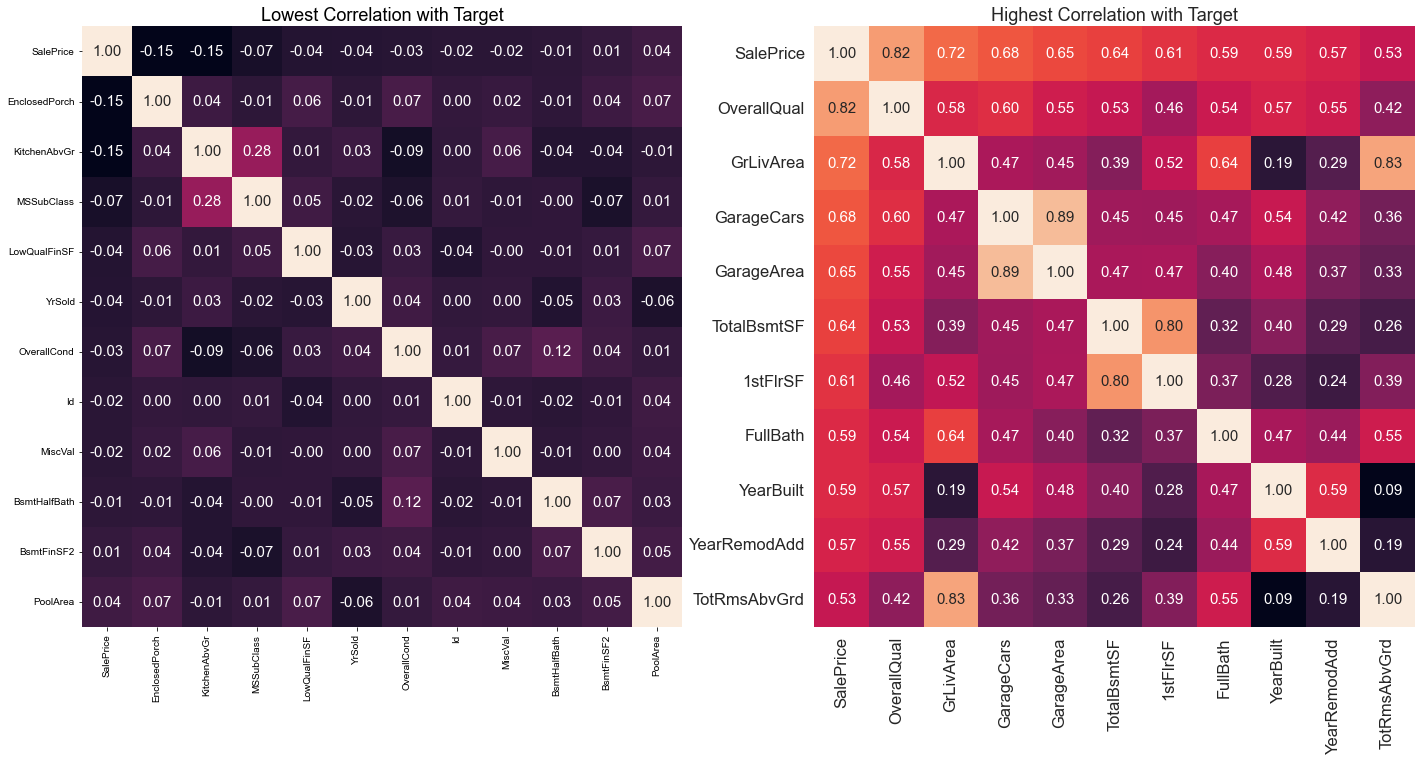

In [14]:
k = 11 #number of variables for heatmap
corrmat = df_train.loc[:, df_train.columns != 'GarageYrBlt'].corr()
plt.figure(figsize=(20,20))
plt.subplot(221)
c = corrmat.nsmallest(k, 'SalePrice')['SalePrice'].index
cols = pd.Index(['SalePrice']).append(c)
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.title('Lowest Correlation with Target')

plt.subplot(222)
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.title('Highest Correlation with Target')
plt.tight_layout()

### Combining DataFrames

In order to properly clean and encode the data, we combine the test and train dataframes. This reduces probablity of errors, code redundancy and ensures that they both have the same shape and columns after one-hot encoding. The Id feature was dropped as it does not describe the SalePrice

In [17]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,7.932610
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,7.878263
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,7.959618
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,7.774955
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,8.002875


In [ ]:
'''
    Dropping Id feature from the two dataframes and storing them in their own dataframes if required later. 
'''
train_id = df_train['Id']
test_id = df_test['Id']
df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

In [18]:
'''
    Save target feature in y-variable, merge dataframes and drop SalePrice column.
'''
train_y = df_train['SalePrice']
df = pd.concat((df_train, df_test), sort=False).reset_index(drop=True)
df.drop('SalePrice', axis=1, inplace=True)

## 1.2 Handling Missing Data

A unique problem of this dataset is the prevalence of NA (or missing) values. After closer inspection of the data description file, we concluded that these values are not indicitave of missing records, but rather that the feature is not present in the house, i.e. the house has no garage. Thus we fill these NA's with 'None' for categorical features and zero for numerical. The remainder were filled with the mode, with the exception of Lotfrontage, MSZoning and GarageYrBlt which were imputed based on their relationship with other features.

In [19]:
'''
    Calculating missing data and displaying it in a dataframe.
'''

# total missing values per column
total = df.isnull().sum().sort_values(ascending=False)
# percentage of missing values
percent = round((df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False),2)
# building df of missing values (Column (as index), Total, Percentage)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])
missing_data.head(10)

,Total,Percentage
PoolQC,2907,99.73
MiscFeature,2810,96.40
Alley,2717,93.21
Fence,2345,80.45
FireplaceQu,1420,48.71
LotFrontage,486,16.67
GarageYrBlt,159,5.45
GarageFinish,159,5.45
GarageQual,159,5.45
GarageCond,159,5.45


In [20]:
'''
Changing columns to categorical variables.
'''
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['OverallCond'] = df['OverallCond'].astype(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

In [21]:
#Running function to convert ordinal data.
OrdinalsToNumerics(df)

In [22]:
'''
    Missing values in these columns describe the data, i.e. there is no garage so GarageType is None.
'''

fill_none = ('FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC', 'GarageType', 'GarageFinish', 
            'GarageQual', 'GarageCond', 'MasVnrType', 'MSSubClass', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
            'BsmtFinType2')
fill_zero = ('GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
            'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea')
fill_mode = ('Exterior1st', 'Exterior2nd', 'SaleType','Functional','Electrical','KitchenQual')

# Looping through columns and filling NAs

for col in fill_none:
    df[col] = df[col].fillna('None')

for col in fill_zero:
    df[col] = df[col].fillna(0)
    
for col in fill_mode:
    df[col] = df[col].fillna(df[col].mode()[0])

In [23]:
'''
    LotFrontage is size of streetfront, fill with Neighborhood median.
    MSZoning is zoning classification, fill with MSSubClass (type of dwelling) mode
    Assume garage was built same year as house, fill with YearBuilt
'''

# Imputing NAs
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(
    lambda x: x.fillna(x.mode()[0]))
df['GarageYrBlt'][df['GarageYrBlt'].isnull()] = df['YearBuilt'][df['GarageYrBlt'].isnull()]

C:\Users\Zandi\AppData\Local\Temp/ipykernel_4440/2332104928.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GarageYrBlt'][df['GarageYrBlt'].isnull()] = df['YearBuilt'][df['GarageYrBlt'].isnull()]


# 2. Feature Engineering

Creating new features to better describe each house

In [24]:
'''
Adding features. 
'''
# Calculating total square footage of house
df['TotalSF'] = df['1stFlrSF']+df['2ndFlrSF']+df['TotalBsmtSF']
# Summing year house was built and remodel
df['YrBltAndRemod']=df['YearBuilt']+df['YearRemodAdd']
# Calculating total bathrooms
df['TotalBathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                        df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
# Calculating total porch square footage
df['TotalPorchSF'] = (df['OpenPorchSF'] + df['3SsnPorch'] + 
                      df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])
# Creating binary columns of features
# Does the house have a pool, 2nd floor? And so forth
df['IsPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['Is2ndFloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['IsGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['IsBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['IsFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


These columns are dropped because they do not have enough diverse features to contribute additional information which can be teased out by the models. 

In [25]:
# creating a list of columns to drop. Columns either have near zero correlation with SalePrice, near zero variance or are used in feature creation
drop_cols = ["Alley", "ExterCond", "BsmtFinSF2", "Heating", "Electrical",\
              "BsmtHalfBath", "PavedDrive", "Fence", "MiscFeature", "MoSold",\
             "BsmtFinType2", "LandContour", "EnclosedPorch",\
              "SaleType", "Functional", "LotConfig",\
              "ScreenPorch", "YrSold", "LandSlope", 'Utilities', 'PoolQC', 'Street']
# dropping columns
for col in [*drop_cols]:
    df.drop([col], axis=1, inplace=True)

# 3. Encoding Data

These functions were defined and described at the head of this notebook. Please refer to their descriptions for further information.

In [36]:
df_norm.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,...,SaleCondition,TotalSF,YrBltAndRemod,TotalBathrooms,TotalPorchSF,IsPool,Is2ndFloor,IsGarage,IsBsmt,IsFireplace
0,60,RL,18.411551,13.814186,Reg,CollgCr,Norm,Norm,1Fam,2Story,...,Normal,40.554814,4006,3.5,18.718778,0.0,1,1,1,0
1,20,RL,20.996309,14.098358,Reg,Veenker,Feedr,Norm,1Fam,1Story,...,Normal,40.308327,3952,2.5,51.564333,0.0,0,1,1,1
2,60,RL,18.946332,14.456068,IR1,CollgCr,Norm,Norm,1Fam,2Story,...,Normal,41.357839,4003,3.5,14.642535,0.0,1,1,1,1
3,70,RL,17.497583,14.086665,IR1,Crawfor,Norm,Norm,1Fam,2Story,...,Abnorml,40.005384,3885,2.0,52.536531,0.0,1,1,1,1
4,60,RL,21.651492,15.000191,IR1,NoRidge,Norm,Norm,1Fam,2Story,...,Normal,44.703279,4000,3.5,49.138571,0.0,1,1,1,1


In [26]:
 df_norm = NormalizeData(df)

C:\Users\Zandi\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Zandi\anaconda3\lib\site-packages\scipy\stats\stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [27]:
# creating dummy variables from the normalized dataframe.
test, X = EncodeData(df_norm)

# 4. Model Selection

In order to find the absolute best model, we use GridSearchCV from sklearn.model_selection. GridSearchCV runs multiple iterations over a specified grid of parameters and selects the best parameter combination. From the documentation: 

"Exhaustive search over specified parameter values for an estimator... The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid."

GridSearchCV also inherets all methods from the passed model and so we can use it in calculating RMSE for test and training data.

In [28]:
# In order to select the best model and the best parameters for
# it we split the training data into a smaller training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, train_y, test_size=0.2, random_state=80)

In [29]:
X_train.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtFinSF1,BsmtUnfSF,...,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1280,23.236421,14.051249,6,1971,1971,0.00000,1.384331,4,0.000000,88.392782,...,0,0,1,0,0,0,0,0,1,0
1136,19.988127,14.148926,6,1977,1977,0.00000,1.384331,4,256.610301,0.000000,...,0,0,0,0,1,0,0,0,1,0
967,20.158390,14.274351,6,1958,1958,14.53705,1.384331,4,115.760933,19.560495,...,0,0,0,0,1,0,0,0,1,0
332,21.813301,14.332952,8,2003,2004,23.71759,1.606791,5,202.574794,123.266474,...,0,0,0,0,1,0,0,0,1,0
501,20.158390,14.145266,7,2005,2005,0.00000,1.606791,5,96.879640,59.340356,...,0,0,0,0,1,0,0,0,1,0


## 4.1 Linear Regression

Due to the complexity of this data set and its large amounts of categorical features, we assume that a simple Linear Regression model won't produce the best accuracy, but we still include it as a benchmark.

In [30]:
# Training the regression fitting model to create the linear regression.
lm = FitModel(LinearRegression(), X_train, y_train)

In [31]:
#Running the testing function to return the results of the linear regression model.
lm_rmse_train = RMSE(y_train, lm.predict(X_train))
lm_rmse_test = RMSE(y_test, lm.predict(X_test))
lm_list = [lm_rmse_train, lm_rmse_test]

print("RMSE train: {}".format(lm_rmse_train))
print("RMSE test: {}".format(lm_rmse_test))

RMSE train: 0.03733097772298069
RMSE test: 2012.645648677942


## 4.2 Ridge

Ridge regression, or Tikhonov regularization handles multicolinearity and small datasets really well. We estimate that this model will have the best performance of the regularized regression models.

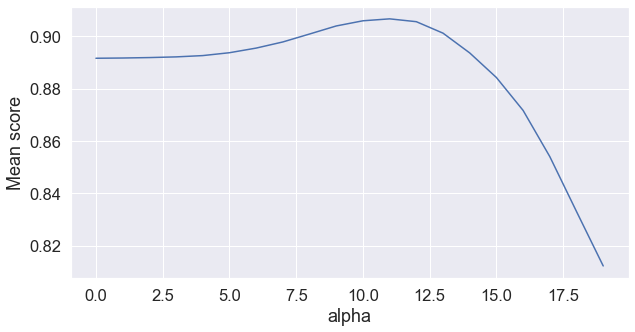

Best params: {'alpha': 4.281332398719396}
RMSE train: 0.03995216866871914
RMSE test : 0.041147142053510624


In [32]:
# Tuning Ridge parameters with GridsearchCV as defined in EvaluateModel
random = 80
params = [{'alpha': np.logspace(-4, 4, 20)}]

ridge_list = EvaluateModel(Ridge(random_state = random), grid_param = params)

## 4.3 LASSO

LASSO, or Least Absolute Shrinkage and Selection Operator applies a penalty to the magnitude of coefficients, shrinking them and in some cases eliminating them from the model. This is useful for variable selection, but performance is affected by categorical features and small data sets.

C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6305924861747212, tolerance: 0.002261031719005301
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6148984030183798, tolerance: 0.0022335877782419735
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6836346471584612, tolerance: 0.0023266170035253107
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Con

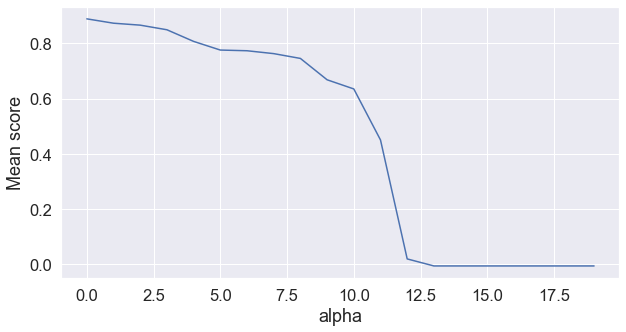

Best params: {'alpha': 0.001}
RMSE train: 0.049144119595273476
RMSE test : 0.039209090157332996


In [33]:
# Tuning LASSO parameters with GridsearchCV as defined in EvaluateModel
random = 80
params = [{'alpha': np.logspace(-3, 4, 20)}]

lasso_list = EvaluateModel(Lasso(random_state = random, normalize=False), grid_param = params)

## 4.4 Elastic Net

Elastic Net linearly combines the L1 and L2 penalties of Ridge and LASSO regression methods. Elastic Net overcomes the limitations of LASSO (tendency to select only one variable from a group of highly correlated variables) by adding the Ridge penalty.

C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8754186575876688, tolerance: 0.002261031719005301
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8614249580793033, tolerance: 0.0022335877782419735
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.959759208106257, tolerance: 0.0023266170035253107
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conv

C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6256930304725525, tolerance: 0.0022119443979479072
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6771652385540566, tolerance: 0.002310935933079186
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0653129594924626, tolerance: 0.002261031719005301
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conv

C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7723884765386289, tolerance: 0.0022335877782419735
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8925250544949863, tolerance: 0.0023266170035253107
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7447463207487741, tolerance: 0.0022119443979479072
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Co

C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5576982289887904, tolerance: 0.002310935933079186
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.538192668549607, tolerance: 0.002261031719005301
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4452033850922046, tolerance: 0.0022335877782419735
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conve

C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.836093676401262, tolerance: 0.0023266170035253107
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5888758212621803, tolerance: 0.0022119443979479072
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8394322885338936, tolerance: 0.002310935933079186
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zandi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conv

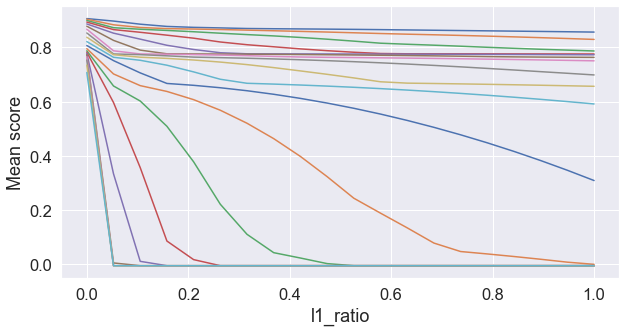

Best params: {'alpha': 0.01, 'l1_ratio': 0.0}
RMSE train: 0.04148765162753821
RMSE test : 0.03894077597238247


In [34]:
# Training the Elastic Net regression with various hyperparameter settings.
random = 80
params = [{'alpha': np.logspace(-2, 4, 20), 'l1_ratio': np.linspace(0, 1, 20)}]

enet_list = EvaluateModel(ElasticNet(random_state = random), grid_param = params)

## 4.5 Finding the Best Model

In [ ]:
index = ['train_RMSE', 'test_RMSE']
compare_models = pd.DataFrame({'LinearRegression': lm_list, 
                               'Ridge': ridge_list, 
                               'LASSO': lasso_list,
                               'ElasticNet': enet_list}, index=index)
compare_models

# 5. Submission

As we show in the comparison above, Ridge gets performs the best of the models we tested. Elastic Net does get a very similar score, but looking at the parameters we can see it almost only used Ridge regularization.

In [ ]:
ridge = FitModel(Ridge(alpha=11.288378916846883, random_state=80), X, train_y)

In [ ]:
Submit(ridge, test, 'final_submit.csv')

In [38]:
# Pickle File of best Model
import pickle
file = open('Ridge_model.pkl','wb')
pickle.dump(ridge_list,file)

# 6. References

https://www.analyticsvidhya.com/blog/2015/08/comprehensive-guide-regression/

Massaron, L. and Boschetti, A. (2016). Regression analysis with Python. Birmingham, UK: Packt Publishing.

Hastie, T., Tibshirani, R. and Friedman, J. (2004). The elements of statistical learning. New York: Springer.